# EMG Data for Gestures

In [58]:
import os
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


In [59]:
def extract_zip(zip_path, extract_to):
    """
    Extracts a zip file to a specified directory.

    Args:
    zip_path (str): The path to the .zip file.
    extract_to (str): The directory where the contents will be extracted.

    Returns:
    bool: True if the extraction was successful, False otherwise.
    """
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)  # Create target directory if it doesn't exist

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"Extracted all files in {zip_path} to {extract_to}")
        return True
    except zipfile.BadZipFile:
        print("Error: Bad ZIP file.")
    except FileNotFoundError:
        print("Error: ZIP file not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    return False

## Paths and variables

In [60]:
id_col = 'subject_trail'
time_col = 'time'
target_col = 'class'

In [61]:
dataset_handle = 'EMG Gestures'
dataset_name = 'emg_gestures'
processed_dir = './../../processed/'
output_dir = f'./../../processed/{dataset_name}/'
os.makedirs(output_dir, exist_ok=True)
full_outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
test_key_outp_fname = os.path.join(output_dir, f'{dataset_name}_test_key.csv')
train_outp_fname = os.path.join(output_dir, f'{dataset_name}_train.csv')
test_outp_fname = os.path.join(output_dir, f'{dataset_name}_test.csv')

## Read the data

In [62]:
if not os.path.exists('./data'):
    extract_zip(f'./data.zip', './')

subject_ids = [i for i in os.listdir('./data') if os.path.isdir(f'./data/{i}')]
paths = [os.path.join('./data', i) for i in subject_ids]
full_data = []
for path in paths:
    files = os.listdir(path)
    file_paths = [os.path.join(path, i) for i in files]

    for file, file_path in zip(files, file_paths):
        trail_number = int(file[0])
        data = pd.read_csv(file_path, sep='\t')
        subject_id = Path(path).name
        id = f'{subject_id}_{trail_number}'
        data.insert(0, id_col, id)

        full_data.append(data)
    
data = pd.concat(full_data)
data.bfill(inplace=True)

<Axes: >

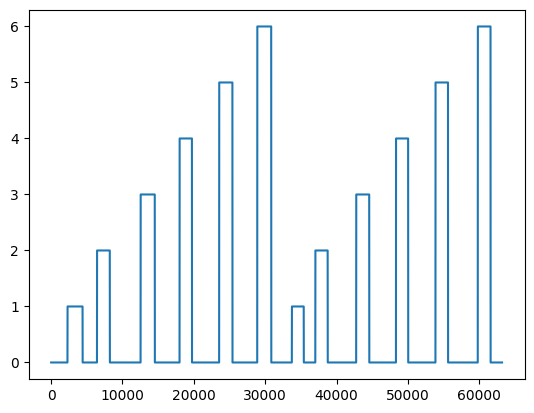

In [63]:
data[data[id_col] == '01_1']['class'].plot()

## Train/Test split

In [64]:
random.seed(42)
# As shown in the plot above, half follows a pattern where all classes appear in the first half and then repeat in the second half.
# Therefore the train-test split is going to be 50/50 to ensure that all classes are present in both sets.
test_size = 0.2
ids = data[id_col].unique().tolist()

# Split data into train and test
num_test_subjects = int(test_size * len(ids))
test_subjects = random.sample(ids, num_test_subjects)
train_subjects = [sid for sid in ids if sid not in test_subjects]

In [65]:
train_df = data[data[id_col].isin(train_subjects)]
test_df = data[data[id_col].isin(test_subjects)]

test_key = test_df[[id_col, time_col, target_col]]
test_df = test_df.drop(columns=[target_col])

In [72]:
def save_df_to_zipped_csv(df, ftype=None): 
    if ftype is not None: 
        suffix = f'_{ftype}'
    else: 
        suffix = ''
        
    zipped_f_name = f'{dataset_name}{suffix}.zip'
    archive_f_name = f'{dataset_name}{suffix}.csv'   
    compression_opts = dict(method='zip',
                        archive_name=archive_f_name)      
    df.to_csv(os.path.join(output_dir, zipped_f_name), index=False, compression=compression_opts )

## Save data

In [73]:
save_df_to_zipped_csv(data)
save_df_to_zipped_csv(train_df, "train")
save_df_to_zipped_csv(test_df, "test")
save_df_to_zipped_csv(test_key, "test_key")
